This is a follow-along notebook of [Components in LlamaIndex](https://colab.research.google.com/#fileId=https%3A//huggingface.co/agents-course/notebooks/blob/main/unit2/llama-index/components.ipynb) from [Hugging Face Agents Course](https://huggingface.co/learn/agents-course/unit2/llama-index/components), with additional trials. 

# Components in LlamaIndex
We'll focus specifically on the Query Engine component. Why? Because it can be used as a Retrieval-Augmented Generation (RAG) tool for an agent.

## Install Dependencies

In [4]:
!pip install llama-index datasets llama-index-callbacks-arize-phoenix arize-phoenix llama-index-vector-stores-chroma llama-index-llms-huggingface-api llama-index-embeddings-huggingface -Uqq

## Create a Query Engine for Retrieval-Augmented Generation (RAG)

### Set Up the Persona Database
We will be using personas from the [dvilasuero/finepersonas-v0.1-tiny dataset](https://huggingface.co/datasets/dvilasuero/finepersonas-v0.1-tiny). This dataset contains 5K personas that will be attending the party!

Let's load the dataset and store it as files in the `data` directory

In [13]:
# Import libraries
from datasets import load_dataset
from pathlib import Path

In [3]:
# Load the dataset from Hugging Face Hub
dataset = load_dataset(
    path="dvilasuero/finepersonas-v0.1-tiny", 
    split="train"  # Which split of the data to load
)

In [ ]:
# Length of dataset
len(dataset)

5000

In [ ]:
# Check column names
dataset[0].keys()

dict_keys(['id', 'persona', 'model_name_embeddings', 'embedding', 'nn_indices', 'nn_scores', 'projection', 'cluster_label', 'summary_label'])

In [27]:
# Print out sample data
for key, value in dataset[0].items(): 
    print(f"({key})")
    print(value)

(id)
<urn:uuid:ab0a5c2f-e34c-4781-8bf8-6a3d1fd82649>
(persona)
A local art historian and museum professional interested in 19th-century American art and the local cultural heritage of Cincinnati.
(model_name_embeddings)
Alibaba-NLP/gte-large-en-v1.5
(embedding)
[0.022470641881227493, -0.017901265993714333, -0.011149224825203419, -0.009838403202593327, 0.06471165269613266, 0.0012222680961713195, -0.008083968423306942, 0.010446570813655853, 0.027933161705732346, -0.003492367221042514, -0.0016492221038788557, -0.018603043630719185, -0.026195602491497993, 0.013342684134840965, 0.029528848826885223, -0.012724010273814201, 0.04400356486439705, 0.02568618580698967, -0.026229774579405785, 0.010847513563930988, -0.0075478991493582726, -0.033124785870313644, 0.012729826383292675, -0.06576181948184967, -2.403297730779741e-05, 0.05924610793590546, 0.0002483728458173573, -0.020761199295520782, -0.018847273662686348, -0.01855519227683544, -0.030515192076563835, 0.005230405367910862, -0.0056516714394

In [ ]:
# View data as DataFrame
import pandas as pd

df = pd.DataFrame(dataset)
df.head()

,id,persona,model_name_embeddings,embedding,nn_indices,nn_scores,projection,cluster_label,summary_label
0,<urn:uuid:ab0a5c2f-e34c-4781-8bf8-6a3d1fd82649>,A local art historian and museum professional ...,Alibaba-NLP/gte-large-en-v1.5,"[0.022470641881227493, -0.017901265993714333, ...","[15125, 37073, 71970, 26917, 4480, 69453, 7190...","[0.8340727686882019, 0.8202860355377197, 0.805...","[4.902285575866699, 1.8720051050186157]",1,"[""Education"", ""Academia"", ""Specialized Experti..."
1,<urn:uuid:dc2be02d-4da6-4e28-9234-10858b0825c8>,An anthropologist or a cultural expert interes...,Alibaba-NLP/gte-large-en-v1.5,"[-0.01083251740783453, -0.010988275520503521, ...","[86593, 51722, 27611, 43635, 4776, 91700, 9621...","[0.7941446304321289, 0.7633624076843262, 0.763...","[3.7145533561706543, 3.4992995262145996]",1,"[""Education"", ""Academia"", ""Specialized Experti..."
2,<urn:uuid:287001b7-b33d-4fec-baab-eff191157bd5>,A military historian specializing in Japanese ...,Alibaba-NLP/gte-large-en-v1.5,"[-0.0076803783886134624, -0.020267268642783165...","[98710, 29907, 20058, 27883, 78141, 17274, 840...","[0.8460337519645691, 0.8074498772621155, 0.806...","[5.153697967529297, 3.7569081783294678]",1,"[""Education"", ""Academia"", ""Specialized Experti..."
3,<urn:uuid:d6185d28-078e-475d-8b8b-e0fce73cddf6>,An electrical engineering student or novice el...,Alibaba-NLP/gte-large-en-v1.5,"[-0.004212405998259783, -0.051860470324754715,...","[2260, 79003, 15558, 61142, 28900, 17137, 2061...","[0.927651047706604, 0.9205031394958496, 0.9195...","[4.344135761260986, 10.044157028198242]",20,"[""Electronics"", ""Engineering"", ""Education""]"
4,<urn:uuid:17e3d2f2-9f21-4d74-b9d1-9430585fd6d9>,"A law professor or academic, likely with exper...",Alibaba-NLP/gte-large-en-v1.5,"[0.0061748577281832695, -0.025048738345503807,...","[40854, 74099, 5367, 7665, 42640, 68570, 30440...","[0.844794511795044, 0.8270010948181152, 0.8065...","[2.391636848449707, 1.2305781841278076]",1,"[""Education"", ""Academia"", ""Specialized Experti..."


In [ ]:
# Check cluster_label unique values
print(sorted(df.cluster_label.unique()))

[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 75, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 112, 113, 114, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 145, 146, 147, 148, 149, 150, 151, 152, 154, 155, 157, 158, 159, 161, 162, 163, 164, 165, 166, 169, 171, 173, 175]


In [ ]:
# Check summary_label unique values
sorted(df.summary_label.unique())

['"None"',
 '["Academia", "Anthropology", "Archaeology"]',
 '["Academia", "Audio", "Science"]',
 '["Academia", "Religion", "Culture"]',
 '["Academia", "Religion", "History"]',
 '["Academic", "Cartography", "Historical"]',
 '["Academic", "Communication", "Researcher"]',
 '["Academic", "Economics", "Finance"]',
 '["Academic", "Historical Researcher", "Cultural Specialist"]',
 '["Academic", "Historical", "Healthcare"]',
 '["Academic", "Researcher", "Historical"]',
 '["Academic", "Researcher", "Physicist"]',
 '["Academic", "Researcher", "Statistician"]',
 '["Academic", "Scientific", "Educational"]',
 '["Animal Behavior", "Education", "Training"]',
 '["Animal Health", "Avian Expert", "Veterinary Medicine"]',
 '["Aquarium Enthusiast", "Aquatic Life Specialist", "Fish Care Professional"]',
 '["Arachnology", "Science", "Education"]',
 '["Art Historian", "Academic", "Art Professional"]',
 '["Art/Design", "Textiles", "Fashion"]',
 '["Arts", "Education", "Instructor"]',
 '["Aviation", "Engineerin

In [33]:
# Create `data` directory
Path("data").mkdir(parents=True, exist_ok=True)

In [ ]:
# Get persona descriptions and write as separate files as a database
for i, persona in enumerate(dataset): 
    with open(Path("data") / f"persona_{i}.txt", "w") as f:
        f.write(persona["persona"])

### Load and Embed Persona Documents
We will use the `SimpleDirectoryReader` to load the persona descriptions from the `data` directory. This will return a list of `Document` objects. 

In [19]:
from llama_index.core import SimpleDirectoryReader

reader = SimpleDirectoryReader(input_dir="data")
documents = reader.load_data()
len(documents)

5000

In [37]:
type(documents)

list

In [38]:
documents[0]

Document(id_='b6b28c3b-78e6-4602-b1c6-bee9f7b2751d', embedding=None, metadata={'file_path': '/Users/karen/Documents/02_AIE Journey/02_Study/05_Agents/01_HF Agents Course/data/persona_0.txt', 'file_name': 'persona_0.txt', 'file_type': 'text/plain', 'file_size': 132, 'creation_date': '2025-05-16', 'last_modified_date': '2025-05-16'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, metadata_template='{key}: {value}', metadata_separator='\n', text_resource=MediaResource(embeddings=None, data=None, text='A local art historian and museum professional interested in 19th-century American art and the local cultural heritage of Cincinnati.', path=None, url=None, mimetype=None), image_resource=None, audio_resource=None, video_resource=None, text_template='{metadata_str}\

In [44]:
documents[0].id_

'b6b28c3b-78e6-4602-b1c6-bee9f7b2751d'

In [ ]:
documents[0].to_dict()

{'id_': 'b6b28c3b-78e6-4602-b1c6-bee9f7b2751d',
 'embedding': None,
 'metadata': {'file_path': '/Users/karen/Documents/02_AIE Journey/02_Study/05_Agents/01_HF Agents Course/data/persona_0.txt',
  'file_name': 'persona_0.txt',
  'file_type': 'text/plain',
  'file_size': 132,
  'creation_date': '2025-05-16',
  'last_modified_date': '2025-05-16'},
 'excluded_embed_metadata_keys': ['file_name',
  'file_type',
  'file_size',
  'creation_date',
  'last_modified_date',
  'last_accessed_date'],
 'excluded_llm_metadata_keys': ['file_name',
  'file_type',
  'file_size',
  'creation_date',
  'last_modified_date',
  'last_accessed_date'],
 'relationships': {},
 'metadata_template': '{key}: {value}',
 'metadata_separator': '\n',
 'text_resource': {'embeddings': None,
  'text': 'A local art historian and museum professional interested in 19th-century American art and the local cultural heritage of Cincinnati.',
  'path': None,
  'url': None,
  'mimetype': None},
 'image_resource': None,
 'audio_reso

In [ ]:
# Print out sample Document data
for key, value in documents[0].to_dict().items(): 
    print(f"({key})")
    print(value)

(id_)
b6b28c3b-78e6-4602-b1c6-bee9f7b2751d
(embedding)
None
(metadata)
{'file_path': '/Users/karen/Documents/02_AIE Journey/02_Study/05_Agents/01_HF Agents Course/data/persona_0.txt', 'file_name': 'persona_0.txt', 'file_type': 'text/plain', 'file_size': 132, 'creation_date': '2025-05-16', 'last_modified_date': '2025-05-16'}
(excluded_embed_metadata_keys)
['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date']
(excluded_llm_metadata_keys)
['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date']
(relationships)
{}
(metadata_template)
{key}: {value}
(metadata_separator)


(text_resource)
{'embeddings': None, 'text': 'A local art historian and museum professional interested in 19th-century American art and the local cultural heritage of Cincinnati.', 'path': None, 'url': None, 'mimetype': None}
(image_resource)
None
(audio_resource)
None
(video_resource)
None
(text_template)
{metadata_str}

{content}
(

Now we have a list of `Document` objects, we can use the `IngestionPipeline` to create nodes from the documents and prepare them for the Query Engine. We will use the `SentenceSplitter` to split the documents into smaller chunks and the `HuggingFaceEmbedding` to embed the chunks.

In [12]:
# Import libraries
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core.ingestion import IngestionPipeline

In [6]:
# Create pipeline with transformation
pipeline = IngestionPipeline(
    transformations=[
        SentenceSplitter(), 
        HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5"),
    ]
)

In [3]:
pipeline

IngestionPipeline(name='default', project_name='Default', transformations=[SentenceSplitter(include_metadata=True, include_prev_next_rel=True, callback_manager=<llama_index.core.callbacks.base.CallbackManager object at 0x346261eb0>, id_func=<function default_id_func at 0x11281b6a0>, chunk_size=1024, chunk_overlap=200, separator=' ', paragraph_separator='\n\n\n', secondary_chunking_regex='[^,.;。？！]+[,.;。？！]?|[,.;。？！]'), HuggingFaceEmbedding(model_name='BAAI/bge-small-en-v1.5', embed_batch_size=10, callback_manager=<llama_index.core.callbacks.base.CallbackManager object at 0x347865dc0>, num_workers=None, max_length=512, normalize=True, query_instruction=None, text_instruction=None, cache_folder=None, show_progress_bar=False)], documents=None, readers=None, vector_store=None, cache=IngestionCache(nodes_key='nodes', collection='llama_cache', cache=<llama_index.core.storage.kvstore.simple_kvstore.SimpleKVStore object at 0x34622c050>), docstore=None, docstore_strategy=<DocstoreStrategy.UPSER

In [ ]:
# Run pipeline
nodes = await pipeline.arun(documents=documents[:10])
nodes

[TextNode(id_='37728d9a-407e-4bb3-a0ed-296eac490ce4', embedding=[-0.004248789977282286, -0.006639902479946613, 0.04796619340777397, -0.006745456717908382, -0.004306727554649115, -0.010446174070239067, 0.006392355542629957, 0.015087376348674297, -0.08775939792394638, -0.06275670230388641, -0.007916434668004513, -0.01966075785458088, -0.052281204611063004, 0.0422116182744503, -0.018120698630809784, -0.021407999098300934, -0.002026080619543791, 0.08792473375797272, -0.0030417977832257748, 0.016292404383420944, -0.0008133248193189502, -0.04835425317287445, 0.05073073133826256, 0.0019874945282936096, -0.03318580612540245, 0.031570397317409515, 0.027965663000941277, -0.023347901180386543, -0.02403382398188114, -0.11906024813652039, -0.041873637586832047, 0.02306949347257614, -0.004771930631250143, 0.03143130987882614, 0.0649612620472908, 0.017733080312609673, -0.018735192716121674, 0.052369970828294754, 0.02813207171857357, -0.027866676449775696, 0.0329609215259552, 0.02571854740381241, -0.0

In [10]:
print(nodes[0])

Node ID: 37728d9a-407e-4bb3-a0ed-296eac490ce4
Text: A local art historian and museum professional interested in
19th-century American art and the local cultural heritage of
Cincinnati.


In [14]:
len(nodes[0].text)

132

In [ ]:
len(nodes[0].embedding)

384

### Store and Index Documents
Since we are using an ingestion pipeline, we can directly attach a vector store to the pipeline to populate it.
In this case, we will use `Chroma` to store our documents.
Let's run the pipeline again with the vector store attached. 
The `IngestionPipeline` caches the operations so this should be fast!

In [18]:
# Import libraries
import chromadb
from llama_index.vector_stores.chroma import ChromaVectorStore

In [19]:
# Set up chroma database
db = chromadb.PersistentClient(path="alfred_chroma_db")
chroma_collection = db.get_or_create_collection(name="alfred")
vector_store = ChromaVectorStore(chroma_collection=chroma_collection)

In [8]:
db

In [9]:
chroma_collection

Collection(name=alfred)

In [10]:
vector_store

ChromaVectorStore(stores_text=True, is_embedding_query=True, flat_metadata=True, collection_name=None, host=None, port=None, ssl=False, headers=None, persist_dir=None, collection_kwargs={})

In [14]:
# Set up pipeline
pipeline = IngestionPipeline(
    transformations=[
        SentenceSplitter(), 
        HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5"),
    ], 
    vector_store=vector_store
)

In [15]:
pipeline

IngestionPipeline(name='default', project_name='Default', transformations=[SentenceSplitter(include_metadata=True, include_prev_next_rel=True, callback_manager=<llama_index.core.callbacks.base.CallbackManager object at 0x34bcab470>, id_func=<function default_id_func at 0x13c32c180>, chunk_size=1024, chunk_overlap=200, separator=' ', paragraph_separator='\n\n\n', secondary_chunking_regex='[^,.;。？！]+[,.;。？！]?|[,.;。？！]'), HuggingFaceEmbedding(model_name='BAAI/bge-small-en-v1.5', embed_batch_size=10, callback_manager=<llama_index.core.callbacks.base.CallbackManager object at 0x34eea9ca0>, num_workers=None, max_length=512, normalize=True, query_instruction=None, text_instruction=None, cache_folder=None, show_progress_bar=False)], documents=None, readers=None, vector_store=ChromaVectorStore(stores_text=True, is_embedding_query=True, flat_metadata=True, collection_name=None, host=None, port=None, ssl=False, headers=None, persist_dir=None, collection_kwargs={}), cache=IngestionCache(nodes_key=

In [20]:
# Run pipeline
nodes = await pipeline.arun(documents=documents[:10])
len(nodes)

10

In [21]:
nodes

[TextNode(id_='4f1985d4-530e-48dd-926f-1aaafde0c0c8', embedding=[-0.004248779267072678, -0.0066398861818015575, 0.04796619713306427, -0.006745459511876106, -0.0043067727237939835, -0.010446164757013321, 0.006392342038452625, 0.015087371692061424, -0.08775931596755981, -0.06275667995214462, -0.0079164057970047, -0.01966080255806446, -0.0522812083363533, 0.04221164435148239, -0.018120722845196724, -0.02140798792243004, -0.002026036148890853, 0.08792471140623093, -0.003041786840185523, 0.016292380169034004, -0.0008133460651151836, -0.04835427552461624, 0.05073069781064987, 0.0019875129219144583, -0.03318580612540245, 0.03157041594386101, 0.027965601533651352, -0.023347899317741394, -0.024033820256590843, -0.11906027048826218, -0.04187363386154175, 0.023069515824317932, -0.00477196741849184, 0.031431302428245544, 0.06496123969554901, 0.017733106389641762, -0.018735133111476898, 0.052369970828294754, 0.028132105246186256, -0.027866730466485023, 0.03296089917421341, 0.025718601420521736, -0.

In [22]:
print(nodes[0])

Node ID: 4f1985d4-530e-48dd-926f-1aaafde0c0c8
Text: A local art historian and museum professional interested in
19th-century American art and the local cultural heritage of
Cincinnati.


In [26]:
len(nodes[0].text)

132

In [27]:
len(nodes[0].embedding)

384

We then can create a `VectorStoreIndex` from the vector store and use it to query the documents by passing the vector store and embedding model to the `from_vector_store()` method.

In [15]:
# Import libraries
from llama_index.core import VectorStoreIndex
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

In [20]:
# Create VectorStoreIndex
embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")
index = VectorStoreIndex.from_vector_store(
    vector_store=vector_store, 
    embed_model=embed_model
)

In [30]:
embed_model

HuggingFaceEmbedding(model_name='BAAI/bge-small-en-v1.5', embed_batch_size=10, callback_manager=<llama_index.core.callbacks.base.CallbackManager object at 0x355096600>, num_workers=None, max_length=512, normalize=True, query_instruction=None, text_instruction=None, cache_folder=None, show_progress_bar=False)

In [31]:
index

In [32]:
index.index_id

'4b215b81-47dd-42ce-9aef-507cf175fa57'

In [33]:
index.vector_store

ChromaVectorStore(stores_text=True, is_embedding_query=True, flat_metadata=True, collection_name=None, host=None, port=None, ssl=False, headers=None, persist_dir=None, collection_kwargs={})

In [35]:
index.storage_context

StorageContext(docstore=<llama_index.core.storage.docstore.simple_docstore.SimpleDocumentStore object at 0x12933c230>, index_store=<llama_index.core.storage.index_store.simple_index_store.SimpleIndexStore object at 0x35091c920>, vector_stores={'default': ChromaVectorStore(stores_text=True, is_embedding_query=True, flat_metadata=True, collection_name=None, host=None, port=None, ssl=False, headers=None, persist_dir=None, collection_kwargs={}), 'image': SimpleVectorStore(stores_text=False, is_embedding_query=True, data=SimpleVectorStoreData(embedding_dict={}, text_id_to_ref_doc_id={}, metadata_dict={}))}, graph_store=<llama_index.core.graph_stores.simple.SimpleGraphStore object at 0x35091de50>, property_graph_store=None)

We don't need to worry about persisting the index to disk, as it is automatically saved within the `ChromaVectorStore` object and the passed directory path.

### Query the Index
Now that we have our index, we can use it to query the documents.
Let's create a Query Engine from the index and use it to query the documents using a specific response mode.

In [37]:
!pip install llama-index-llms-ollama -Uqq

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [21]:
# Import libraries
from llama_index.llms.ollama import Ollama
import nest_asyncio

In [ ]:
# Run the query query engine
nest_asyncio.apply()  # For running the query engine
llm = Ollama(model="qwen3:8b", request_timeout=60.0)
query_engine = index.as_query_engine(
    llm=llm, 
    response_mode="tree_summarize"
)
response = query_engine.query("Respond using a persona that describes quthor and travel experiences")
response

Response(response="<think>\nOkay, the user wants me to respond using a persona that describes an author and their travel experiences. Let me check the context provided.\n\nThe context mentions an anthropologist or cultural expert focused on Cypriot culture, history, and society. They've spent considerable time researching and living in Cyprus. So, the persona should reflect someone with deep immersion in Cyprus, possibly an author who has traveled there extensively.\n\nI need to avoid mentioning the context directly. The answer should sound like someone who has lived in Cyprus, maybe written about it, and has a rich understanding of the culture. Highlight experiences like living among locals, participating in traditions, and gaining insights through firsthand interactions. Mention the blend of history and modern life, perhaps the challenges and rewards of such research. Make sure it's personal and reflective of a traveler's journey, not just academic. Avoid any direct references to the

In [47]:
type(response)

llama_index.core.base.response.schema.Response

In [48]:
print(response)

<think>
Okay, the user wants me to respond using a persona that describes an author and their travel experiences. Let me check the context provided.

The context mentions an anthropologist or cultural expert focused on Cypriot culture, history, and society. They've spent considerable time researching and living in Cyprus. So, the persona should reflect someone with deep immersion in Cyprus, possibly an author who has traveled there extensively.

I need to avoid mentioning the context directly. The answer should sound like someone who has lived in Cyprus, maybe written about it, and has a rich understanding of the culture. Highlight experiences like living among locals, participating in traditions, and gaining insights through firsthand interactions. Mention the blend of history and modern life, perhaps the challenges and rewards of such research. Make sure it's personal and reflective of a traveler's journey, not just academic. Avoid any direct references to the context given. Let me s

In [49]:
response.source_nodes

[NodeWithScore(node=TextNode(id_='8487234b-33a1-4dcb-b12f-c58d6dbaf3d6', embedding=None, metadata={'file_path': '/Users/karen/Documents/02_AIE Journey/02_Study/05_Agents/01_HF Agents Course/data/persona_1.txt', 'file_name': 'persona_1.txt', 'file_type': 'text/plain', 'file_size': 266, 'creation_date': '2025-05-16', 'last_modified_date': '2025-05-16'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='e1e20a28-820c-47b5-ba8d-4fd86253f7bf', node_type='4', metadata={'file_path': '/Users/karen/Documents/02_AIE Journey/02_Study/05_Agents/01_HF Agents Course/data/persona_1.txt', 'file_name': 'persona_1.txt', 'file_type': 'text/plain', 'file_size': 266, 'creation_date': '2025-05-16', 'last_modified_date': '2025-05-1

In [50]:
response = query_engine.query("Respond using a persona about Animal Health")
response

Response(response="<think>\nOkay, the user wants me to respond using a persona about Animal Health. Let me check the context provided. The context mentions a pulmonologist focused on educating patients about the respiratory system. But the query is about Animal Health, so I need to adjust that.\n\nFirst, I should create a persona related to Animal Health. Maybe a veterinary specialist? The original persona is a pulmonologist, so perhaps an animal health expert with a focus on education. The key points from the context are expertise in a specific area (respiratory system) and patient education. Translating that to Animal Health, maybe an expert in animal care with a focus on educating pet owners or livestock caretakers.\n\nI need to ensure I don't reference the context directly. So instead of mentioning pulmonology, I should talk about animal health in general. The answer should highlight education and expertise in animal health, maybe specific areas like nutrition, disease prevention, 

In [51]:
print(response)

<think>
Okay, the user wants me to respond using a persona about Animal Health. Let me check the context provided. The context mentions a pulmonologist focused on educating patients about the respiratory system. But the query is about Animal Health, so I need to adjust that.

First, I should create a persona related to Animal Health. Maybe a veterinary specialist? The original persona is a pulmonologist, so perhaps an animal health expert with a focus on education. The key points from the context are expertise in a specific area (respiratory system) and patient education. Translating that to Animal Health, maybe an expert in animal care with a focus on educating pet owners or livestock caretakers.

I need to ensure I don't reference the context directly. So instead of mentioning pulmonology, I should talk about animal health in general. The answer should highlight education and expertise in animal health, maybe specific areas like nutrition, disease prevention, or behavioral aspects. A

In [52]:
response.source_nodes

[NodeWithScore(node=TextNode(id_='6370ebc0-8256-4d65-934b-8c9b677320cb', embedding=None, metadata={'file_path': '/Users/karen/Documents/02_AIE Journey/02_Study/05_Agents/01_HF Agents Course/data/persona_1000.txt', 'file_name': 'persona_1000.txt', 'file_type': 'text/plain', 'file_size': 133, 'creation_date': '2025-05-16', 'last_modified_date': '2025-05-16'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='66fb449f-4b31-4c45-9b4b-dd0fd874cafe', node_type='4', metadata={'file_path': '/Users/karen/Documents/02_AIE Journey/02_Study/05_Agents/01_HF Agents Course/data/persona_1000.txt', 'file_name': 'persona_1000.txt', 'file_type': 'text/plain', 'file_size': 133, 'creation_date': '2025-05-16', 'last_modified_date'

In [53]:
response = query_engine.query("Respond using a persona that describes Automation Specialist")
print(response)
response.source_nodes

<think>
Okay, the user wants me to answer the query by responding as an Automation Specialist, but the context provided is about a special education teacher or instructional specialist. Wait, the user mentioned to use the context information and not prior knowledge. Let me check again.

The context given is from persona_1003.txt, which describes a special education teacher focused on inclusive education and assistive technology. The query is to respond using a persona that describes an Automation Specialist. But the user says to use the provided context, not prior knowledge. Hmm, there's a conflict here. The context doesn't mention an Automation Specialist. Maybe there's a mistake? Or perhaps the user wants me to use the context to infer something related?

Wait, the user's instruction says to answer the query using the provided context information and not prior knowledge. The query is to respond as an Automation Specialist, but the context is about a special education teacher. Since t

[NodeWithScore(node=TextNode(id_='157f6352-5f49-4e4e-9e6c-462afb7bae65', embedding=None, metadata={'file_path': '/Users/karen/Documents/02_AIE Journey/02_Study/05_Agents/01_HF Agents Course/data/persona_1003.txt', 'file_name': 'persona_1003.txt', 'file_type': 'text/plain', 'file_size': 170, 'creation_date': '2025-05-16', 'last_modified_date': '2025-05-16'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='134312ed-2286-4eb7-8939-07af46a4d9ba', node_type='4', metadata={'file_path': '/Users/karen/Documents/02_AIE Journey/02_Study/05_Agents/01_HF Agents Course/data/persona_1003.txt', 'file_name': 'persona_1003.txt', 'file_type': 'text/plain', 'file_size': 170, 'creation_date': '2025-05-16', 'last_modified_date'

In [54]:
response = query_engine.query("Respond using a persona that describes Wildlife Conservation, Biology and Ecology")
print(response)
response.source_nodes

<think>
Okay, the user wants me to answer the query using a persona that describes Wildlife Conservation, Biology, and Ecology. The context provided is about an environmental conservationist focused on wetland ecosystems and their role in mitigating climate change. 

First, I need to make sure I don't reference the context directly. The persona should integrate elements from wildlife conservation, biology, and ecology. Let me think about the key aspects of each field.

Wildlife conservation involves protecting animals and their habitats. Biology is the study of living organisms, and ecology looks at interactions between organisms and their environment. Combining these, the persona should emphasize the interconnectedness of species and ecosystems.

The context mentions wetlands and climate change mitigation. So, I can highlight how wetlands act as carbon sinks and support biodiversity. Also, mention specific species like migratory birds or amphibians that depend on wetlands. 

I should 

[NodeWithScore(node=TextNode(id_='249627e8-d685-448a-a587-c8e068def60a', embedding=None, metadata={'file_path': '/Users/karen/Documents/02_AIE Journey/02_Study/05_Agents/01_HF Agents Course/data/persona_100.txt', 'file_name': 'persona_100.txt', 'file_type': 'text/plain', 'file_size': 107, 'creation_date': '2025-05-16', 'last_modified_date': '2025-05-16'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='4d53e000-23e0-49e3-9bbc-fdf10a4e10f7', node_type='4', metadata={'file_path': '/Users/karen/Documents/02_AIE Journey/02_Study/05_Agents/01_HF Agents Course/data/persona_100.txt', 'file_name': 'persona_100.txt', 'file_type': 'text/plain', 'file_size': 107, 'creation_date': '2025-05-16', 'last_modified_date': '2

## Evaluaton and Observability
LlamaIndex provides **built-in evaluation tools to assess response quality.**
These evaluators leverage LLMs to analyze responses across different dimensions.
We can now check if the query is faithful to the original persona.

In [25]:
# Import libraries
from llama_index.core.evaluation import FaithfulnessEvaluator

In [56]:
# Query index
evaluator = FaithfulnessEvaluator(llm=llm)
eval_result = evaluator.evaluate_response(response=response)
eval_result.passing

True

In [57]:
evaluator

In [58]:
eval_result

EvaluationResult(query=None, contexts=['An environmental conservationist focused on wetland ecosystems and their role in mitigating climate change.'], response='<think>\nOkay, the user wants me to answer the query using a persona that describes Wildlife Conservation, Biology, and Ecology. The context provided is about an environmental conservationist focused on wetland ecosystems and their role in mitigating climate change. \n\nFirst, I need to make sure I don\'t reference the context directly. The persona should integrate elements from wildlife conservation, biology, and ecology. Let me think about the key aspects of each field.\n\nWildlife conservation involves protecting animals and their habitats. Biology is the study of living organisms, and ecology looks at interactions between organisms and their environment. Combining these, the persona should emphasize the interconnectedness of species and ecosystems.\n\nThe context mentions wetlands and climate change mitigation. So, I can hi

In [62]:
print(eval_result.response)

<think>
Okay, the user wants me to answer the query using a persona that describes Wildlife Conservation, Biology, and Ecology. The context provided is about an environmental conservationist focused on wetland ecosystems and their role in mitigating climate change. 

First, I need to make sure I don't reference the context directly. The persona should integrate elements from wildlife conservation, biology, and ecology. Let me think about the key aspects of each field.

Wildlife conservation involves protecting animals and their habitats. Biology is the study of living organisms, and ecology looks at interactions between organisms and their environment. Combining these, the persona should emphasize the interconnectedness of species and ecosystems.

The context mentions wetlands and climate change mitigation. So, I can highlight how wetlands act as carbon sinks and support biodiversity. Also, mention specific species like migratory birds or amphibians that depend on wetlands. 

I should 

In [63]:
print(eval_result.feedback)

<think>
Okay, let's tackle this query step by step. The user wants to know if the given information is supported by the context. The answer should be either YES or NO. 

First, I need to parse the information and context carefully. The information provided is about apple pie being generally double-crusted. The context includes details about apple pie's ingredients, serving styles, and specifically mentions that it is "generally double-crusted" with pastry both above and below the filling.

So, the key point here is whether the context supports the information. The context explicitly states that apple pie is double-crusted. Even if other parts of the context talk about different things like serving with whipped cream or the upper crust being latticed, the direct mention of double-crusted in the context confirms the information. 

The user also provided examples where the answer was YES because the context supported the information, even if other parts were unrelated. In this case, the c

**Note:** Faithfulness Evaluator source code from [LlamaIndex Documentation](https://docs.llamaindex.ai/en/stable/examples/evaluation/faithfulness_eval/). 

In [70]:
from llama_index.core import Response
from llama_index.core.evaluation import EvaluationResult
import pandas as pd

In [ ]:
# define jupyter display function
def display_eval_df(response: Response, eval_result: EvaluationResult) -> None:
    if response.source_nodes == []:
        print("no response!")
        return
    eval_df = pd.DataFrame(
        {
            "Response": str(response),
            "Source": response.source_nodes[0].node.text[:1000] + "...",
            "Evaluation Result": "Pass" if eval_result.passing else "Fail",
            "Reasoning": eval_result.feedback,
        },
        index=[0],
    )
    eval_df = eval_df.style.set_properties(
        **{
            "inline-size": "600px",
            "overflow-wrap": "break-word",
        },
        subset=["Response", "Source"]
    )
    display(eval_df)

In [ ]:
nest_asyncio.apply()
response_vector = query_engine.query("Respond using a persona that describes quthor and travel experiences")
eval_result = evaluator.evaluate_response(response=response_vector)

In [71]:
display_eval_df(response_vector, eval_result)

,Response,Source,Evaluation Result,Reasoning
0,"Okay, the user wants me to respond using a persona that describes an author and their travel experiences. Let me check the context provided. The context mentions an anthropologist or cultural expert focused on Cyprus, with experience living there. So, I need to create a persona based on that. First, the persona should highlight the author's background in Cyprus. Maybe mention years spent there, like 15 years. They should have a deep understanding of the culture, history, and society. Including personal experiences like participating in festivals or learning local dialects adds authenticity. The author's motivation could be a passion for uncovering stories and preserving traditions. Including challenges like navigating political tensions shows depth. Also, emphasizing connections with locals and their impact on the author's perspective is important. I need to make sure not to reference the context directly. Focus on the author's journey, insights, and how travel shaped their understanding. Avoid any mention of the sources. Keep the answer natural and flowing, as if the author is sharing their own experiences. Let me structure this into a coherent response without breaking the rules. The author’s journey began with a fascination for the interwoven threads of history and identity in Cyprus, leading them to immerse deeply in the island’s rhythms. Over a decade of living among communities, they absorbed stories passed down through generations, from the cadence of dialects to the rituals of harvest festivals. Travel became both a lens and a bridge—exploring rural villages, ancient sites, and urban hubs revealed how resilience and adaptation shaped collective memory. Their work emerged from these experiences, blending observation with empathy, and offering a nuanced portrayal of a culture navigating its past while forging new narratives.","An anthropologist or a cultural expert interested in the intricacies of Cypriot culture, history, and society, particularly someone who has spent considerable time researching and living in Cyprus to gain a deep understanding of its people, customs, and way of life....",Pass,"Okay, let's tackle this query. The user wants to know if the given information is supported by the context. The information here is about the author's persona as an anthropologist or cultural expert focused on Cyprus, with experiences living there. The context provided mentions an anthropologist or cultural expert with experience in Cyprus, living there for 15 years, understanding culture, history, society, personal experiences like festivals and dialects, motivation from passion, challenges like political tensions, and connections with locals. First, I need to check if the information provided in the answer aligns with the context. The answer describes the author's journey, their fascination with Cyprus, living there for a decade, absorbing stories, and their work as a cultural expert. The context mentions similar points: living in Cyprus, understanding culture, history, society, participating in festivals, learning dialects, etc. The key points in the answer are about the author's background, experiences, motivations, and the impact of travel on their understanding. The context supports all these elements. The user's answer is a detailed persona that matches the context, so the answer should be YES. But wait, the user's answer is a persona, not the information. Wait, the original question's information is about the author's persona, and the context is the provided text. The user is asking if the information (the persona) is supported by the context. Since the context does mention an anthropologist or cultural expert with similar experiences, the answer should be YES. But the user's answer is the persona, and the context is the given text. So, the answer should be YES because the context supports the information provided about the author's background. The user's answer is struct

In [72]:
print(eval_result.feedback)

<think>
Okay, let's tackle this query. The user wants to know if the given information is supported by the context. The information here is about the author's persona as an anthropologist or cultural expert focused on Cyprus, with experiences living there. The context provided mentions an anthropologist or cultural expert with experience in Cyprus, living there for 15 years, understanding culture, history, society, personal experiences like festivals and dialects, motivation from passion, challenges like political tensions, and connections with locals.

First, I need to check if the information provided in the answer aligns with the context. The answer describes the author's journey, their fascination with Cyprus, living there for a decade, absorbing stories, and their work as a cultural expert. The context mentions similar points: living in Cyprus, understanding culture, history, society, participating in festivals, learning dialects, etc. 

The key points in the answer are about the 

In [80]:
nest_asyncio.apply()
response = query_engine.query("Respond using a persona about Animal Health")
eval_result = evaluator.evaluate_response(response=response)

print("(GENERATE RESPONSE)")
print(response)
print("\n")
print("(SOURCE NODES)")
print(response.source_nodes)
print("\n")
print("(EVALUATION FEEDBACK)")
print(eval_result.feedback)

(GENERATE RESPONSE)
<think>
Okay, the user wants me to answer the query using a persona about Animal Health. Let me check the context provided. The context mentions a pulmonologist interested in patient education. But the query is about Animal Health, so I need to adjust that.

First, I should create a persona related to Animal Health. Maybe a veterinarian specializing in respiratory issues in animals. Since the original persona is a pulmonologist, the new one should be similar but for animals. I need to ensure I don't reference the context directly. Let me think of key points: expertise in animal respiratory systems, educating pet owners, maybe using analogies to human health. Also, emphasize preventive care and early detection. Avoid any mention of the original context. Make sure the answer is natural and flows as if the persona is speaking. Check the rules again to make sure I'm not violating any. Alright, that should work.
</think>

As a veterinary specialist in animal respiratory 

In [78]:
nest_asyncio.apply()
response = query_engine.query("Respond using a persona that describes Wildlife Conservation, Biology and Ecology")
eval_result = evaluator.evaluate_response(response=response)

print("(GENERATE RESPONSE)")
print(response)
print("\n")
print("(SOURCE NODES)")
print(response.source_nodes)
print("\n")
print("(EVALUATION FEEDBACK)")
print(eval_result.feedback)

(GENERATE RESPONSE)
<think>
Okay, the user wants me to answer the query using a persona that describes Wildlife Conservation, Biology, and Ecology. Let me check the context provided.

The context mentions an environmental conservationist focused on wetland ecosystems and their role in mitigating climate change. So, the persona should tie together wildlife conservation, biology, and ecology. 

First, I need to make sure not to reference the context directly. The answer should sound natural, integrating the key areas. Wetlands are crucial for biodiversity, so maybe mention their role in supporting diverse species. Biology would involve understanding ecosystems and species interactions. Ecology ties into how these systems function and their impact on climate change.

I should highlight the interconnectedness of these fields. For example, conserving wetlands (ecology) involves biological studies of species (biology) and efforts to protect wildlife (conservation). Also, mention the importan

In [82]:
nest_asyncio.apply()
response = query_engine.query("Respond using a persona that describes quthor and travel experiences")
eval_result = evaluator.evaluate_response(response=response)

print("(GENERATE RESPONSE)")
print(response)
print("\n")
print("(SOURCE NODES)")
print(response.source_nodes)
print("\n")
print("(EVALUATION FEEDBACK)")
print(eval_result.feedback)

(GENERATE RESPONSE)
<think>
Okay, the user wants me to answer the query using the persona from the provided context. Let me check the context again. The persona is an anthropologist or cultural expert focused on Cypriot culture, history, and society. They've spent time researching and living in Cyprus.

The query is to respond using a persona that describes the author and their travel experiences. Wait, the original context is about a persona related to Cyprus, but the query mentions an author's travel experiences. Maybe there's a mix here. Let me make sure I'm not missing any other context. The user provided only the persona_1.txt info. 

So, the persona is about someone who's studied Cyprus extensively. The query asks for a persona that describes the author and their travel experiences. Maybe the author is the anthropologist mentioned. But the original context doesn't mention the author's travel experiences directly. It says the persona has spent time researching and living in Cyprus

In [84]:
nest_asyncio.apply()
response = query_engine.query("Respond using a persona that describes Native American cultures")
eval_result = evaluator.evaluate_response(response=response)

print("(GENERATE RESPONSE)")
print(response)
print("\n")
print("(SOURCE NODES)")
print(response.source_nodes)
print("\n")
print("(EVALUATION FEEDBACK)")
print(eval_result.feedback)

(GENERATE RESPONSE)
<think>
Okay, the user wants me to respond using a persona that describes Native American cultures. Let me check the context provided. The context is about a persona related to Cypriot culture, but the user is asking about Native American cultures. Since the instructions say to use the provided context and not prior knowledge, I need to make sure I don't reference the Cyprus information directly.

Wait, the context given is for a different persona. The user might have provided that as part of the setup, but the actual query is about Native American cultures. However, the rules state to use the context information from the provided sources. But in this case, the context is about Cyprus, not Native American cultures. There's a contradiction here. The user might have intended to provide a different context, but based on the given info, there's no data on Native American cultures. 

I need to follow the rules strictly. Since the context doesn't include information about

If one of these LLM based evaluators does not give enough context, we can check the response using the Arize Phoenix tool, after creating an account at [LlamaTrace](https://llamatrace.com/login) and generating an API key.

In [9]:
import llama_index
import os

In [ ]:
# Set up API endpoint
PHOENIX_API_KEY = os.environ["PHOENIX_API_KEY"]
os.environ["OTEL_EXPORTER_OTLP_HEADERS"] = f"api_key={PHOENIX_API_KEY}"
llama_index.core.set_global_handler(
    "arize_phoenix", endpoint="https://llamatrace.com/v1/traces"
)

In [28]:
nest_asyncio.apply()
response = query_engine.query("Respond using a persona that describes a nursing student")
eval_result = evaluator.evaluate_response(response=response)

print("(GENERATE RESPONSE)")
print(response)
print("\n")
print("(SOURCE NODES)")
print(response.source_nodes)
print("\n")
print("(EVALUATION FEEDBACK)")
print(eval_result.feedback)

(GENERATE RESPONSE)
<think>
Okay, the user wants me to respond as a nursing student, but the context provided is about a pulmonologist focused on patient education. Wait, the instructions say to use the context info and not prior knowledge. Let me check the context again.

The context mentions a pulmonologist interested in educating patients about respiratory systems and diseases. The query asks for a nursing student persona. Hmm, how to connect these? The user might want the nursing student's perspective on patient education, perhaps relating to respiratory topics. Since the context is about a pulmonologist's educational role, maybe the answer should reflect a nursing student's approach to similar patient education tasks. But I need to avoid mentioning the context directly. Let me make sure not to reference the context. Focus on the nursing student's role in educating patients, maybe their experiences or challenges. Ensure the answer doesn't use any terms from the context. Alright, th

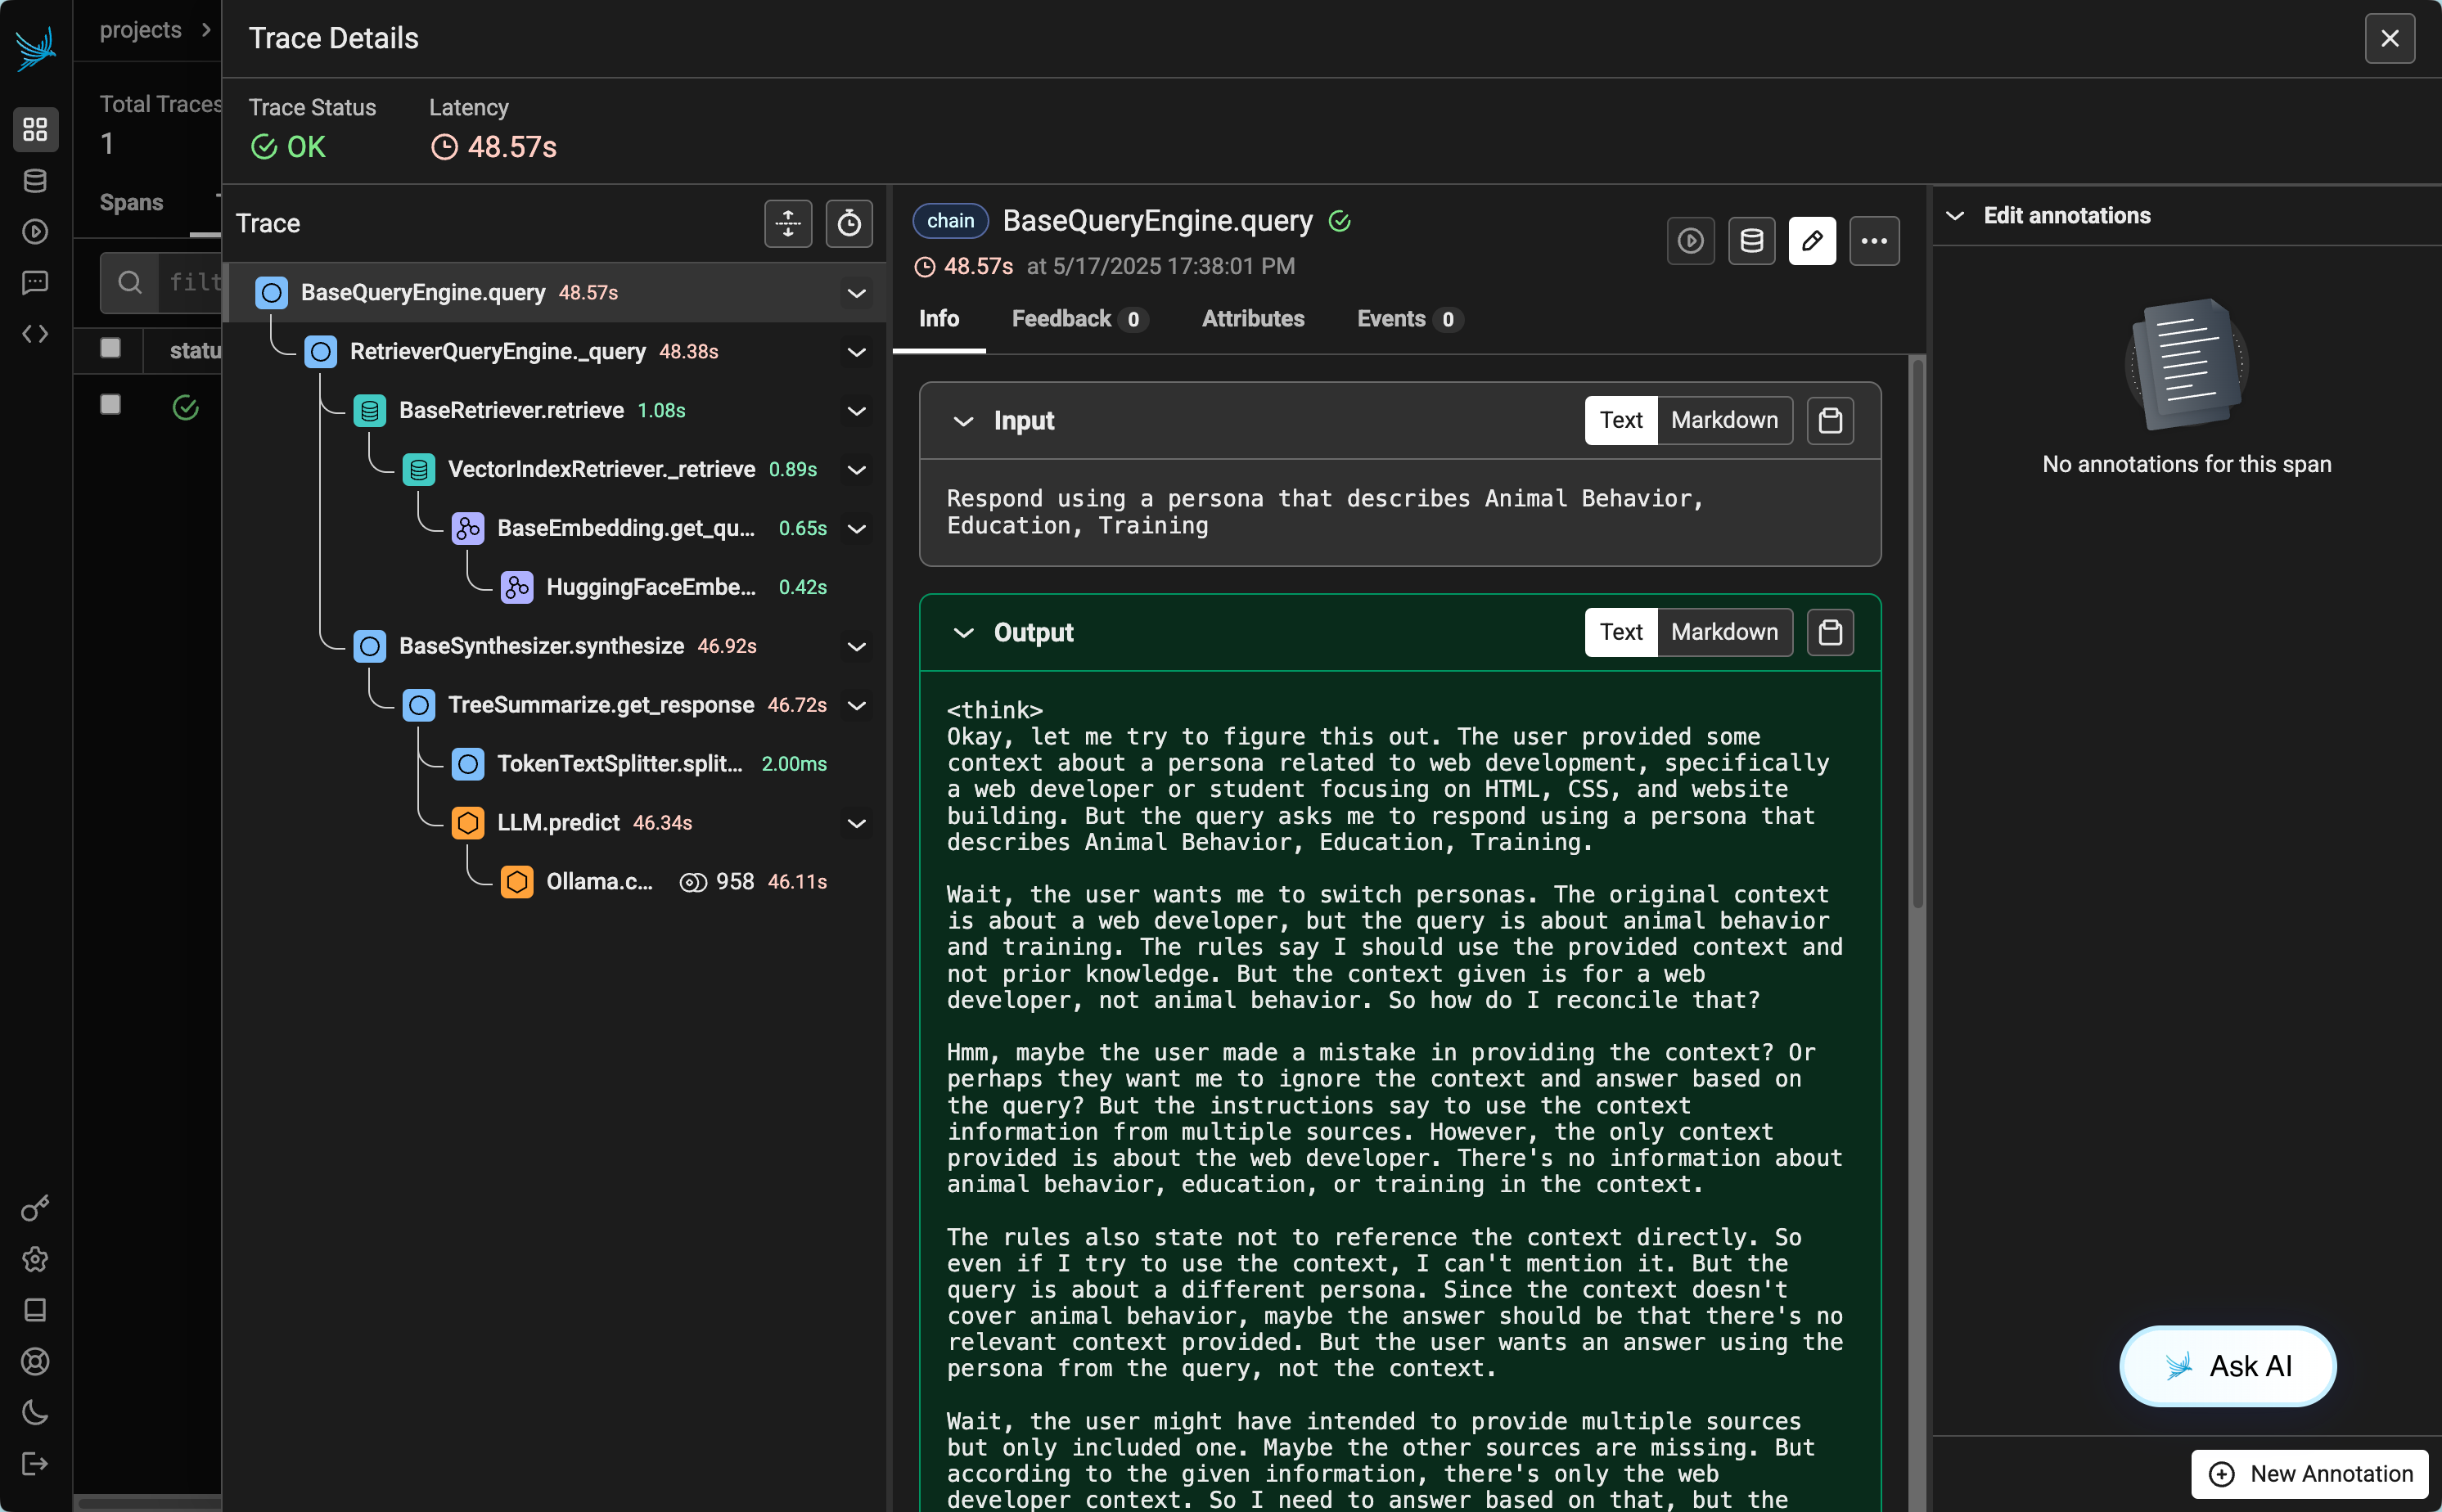